In [20]:
# Imports
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from preprocessing import preprocess_dataset


In [7]:
# Load the preprocessed features dataset
X_path = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\guided\guided_dataset_X.npy'
Y_path = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\guided\guided_dataset_Y.npy'

X_train_features, Y_train, X_val_features, Y_val = preprocess_dataset(X_path, Y_path, mode='features')

# Reshape per session
n_sessions, n_windows, n_electrodes, n_features_per_electrode = X_train_features.shape
X_train = X_train_features.reshape(n_sessions, n_windows, -1)  # (sessions, windows, 8*12)
n_sessions, n_windows, n_joints = Y_train.shape
Y_train = Y_train.reshape(n_sessions, n_windows, n_joints)

print("X_train shape (after reshaping):", X_train.shape)
print("Y_train shape (after reshaping):", Y_train.shape)

X_train shape (after reshaping): (4, 2296, 96)
Y_train shape (after reshaping): (4, 2296, 51)


In [18]:
# Helper to get joint indices from bone index
def bone_to_joint_indices(bone_idx):
    return [3*bone_idx, 3*bone_idx + 1, 3*bone_idx + 2]

# Now define all groups (fingers + wrist + palm)
group_bones = {
    'wrist': [0],
    'thumb': [1, 2, 3],
    'index': [4, 5, 6],
    'middle': [7, 8, 9],
    'ring': [10, 11, 12],
    'palm': [13],
    'little': [14, 15, 16]
}

# Create joint indices for each group
group_joint_indices = {}
for group, bones in group_bones.items():
    joints = []
    for bone in bones:
        joints.extend(bone_to_joint_indices(bone))
    group_joint_indices[group] = joints

# (Optional) print and check
for group, joints in group_joint_indices.items():
    print(f"{group.capitalize()} joint indices: {joints}")


Wrist joint indices: [0, 1, 2]
Thumb joint indices: [3, 4, 5, 6, 7, 8, 9, 10, 11]
Index joint indices: [12, 13, 14, 15, 16, 17, 18, 19, 20]
Middle joint indices: [21, 22, 23, 24, 25, 26, 27, 28, 29]
Ring joint indices: [30, 31, 32, 33, 34, 35, 36, 37, 38]
Palm joint indices: [39, 40, 41]
Little joint indices: [42, 43, 44, 45, 46, 47, 48, 49, 50]


## Ridge regression

In [ ]:
# --- Ridge Regression with Leave-One-Session-Out Cross-Validation ---
print("\nTesting Ridge Regression with Session-Based CV")

ridge_cv_rmse = []
ridge_cv_nrmse = []

for val_session in tqdm(range(4), desc='Cross-Validation Progress'):
    train_sessions = [s for s in range(4) if s != val_session]
    
    X_train_fold = X_train[train_sessions].reshape(-1, X_train.shape[-1])
    Y_train_fold = Y_train[train_sessions].reshape(-1, Y_train.shape[-1])
    
    X_val_fold = X_train[val_session]
    Y_val_fold = Y_train[val_session]
    
    model = MultiOutputRegressor(Ridge(alpha=1.0, fit_intercept=True))
    model.fit(X_train_fold, Y_train_fold)
    preds = model.predict(X_val_fold)
    
    rmse = np.sqrt(np.mean((preds - Y_val_fold) ** 2))
    ridge_cv_rmse.append(rmse)
    
    std_ground_truth = np.std(Y_val_fold)
    nrmse = rmse / std_ground_truth
    ridge_cv_nrmse.append(nrmse)

    # Print RMSE and NRMSE for this fold
    print(f"Fold {val_session}: RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}")

ridge_cv_rmse = np.array(ridge_cv_rmse)
ridge_cv_nrmse = np.array(ridge_cv_nrmse)

print(f"Session-Based Ridge CV RMSE: {ridge_cv_rmse.mean():.4f} (+/- {ridge_cv_rmse.std():.4f})")
print(f"Session-Based Ridge CV NRMSE: {ridge_cv_nrmse.mean():.4f} (+/- {ridge_cv_nrmse.std():.4f})")


Testing Ridge Regression with Session-Based CV


Cross-Validation Progress: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

Session-Based Ridge CV RMSE: 7.0058 (+/- 0.5449)
Session-Based Ridge CV NRMSE: 0.3255 (+/- 0.0247)


Alpha Search: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


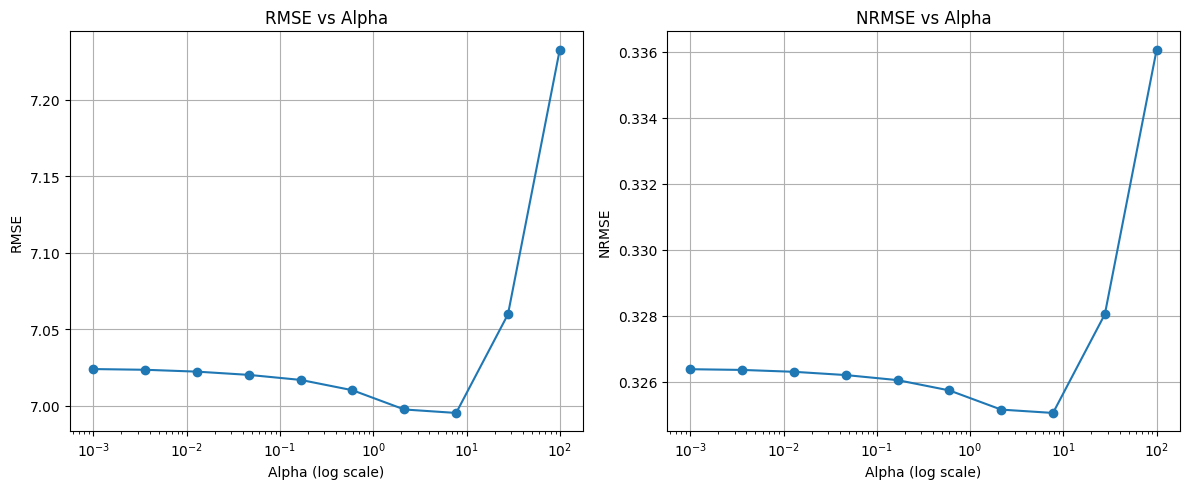

In [ ]:
alphas = np.logspace(-3, 2, 10)  # 0.001 to 100
rmse_list = []
nrmse_list = []

for alpha in tqdm(alphas, desc='Alpha Search'):
    ridge_cv_rmse = []
    ridge_cv_nrmse = []

    for val_session in range(4):
        train_sessions = [s for s in range(4) if s != val_session]

        X_train_fold = X_train[train_sessions].reshape(-1, X_train.shape[-1])
        Y_train_fold = Y_train[train_sessions].reshape(-1, Y_train.shape[-1])

        X_val_fold = X_train[val_session]
        Y_val_fold = Y_train[val_session]

        model = MultiOutputRegressor(Ridge(alpha=alpha, fit_intercept=True))
        model.fit(X_train_fold, Y_train_fold)
        preds = model.predict(X_val_fold)

        rmse = np.sqrt(np.mean((preds - Y_val_fold) ** 2))
        std_ground_truth = np.std(Y_val_fold)
        nrmse = rmse / std_ground_truth

        ridge_cv_rmse.append(rmse)
        ridge_cv_nrmse.append(nrmse)

    rmse_list.append(np.mean(ridge_cv_rmse))
    nrmse_list.append(np.mean(ridge_cv_nrmse))

# --- Plotting ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.semilogx(alphas, rmse_list, marker='o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('RMSE')
plt.title('RMSE vs Alpha')
plt.grid(True)

plt.subplot(1,2,2)
plt.semilogx(alphas, nrmse_list, marker='o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('NRMSE')
plt.title('NRMSE vs Alpha')
plt.grid(True)

plt.tight_layout()
plt.show()


## Chain Ridge regression

In [ ]:
# RegressionChain x group: wrist, thumb, index, middle, ring, little, palm

# --- RegressorChains with Leave-One-Session-Out Cross-Validation ---
print("\nTesting Regressor Chains per Finger with Session-Based CV")

chain_cv_rmse = []
chain_cv_nrmse = []

for val_session in tqdm(range(4), desc='Cross-Validation Progress'):
    train_sessions = [s for s in range(4) if s != val_session]

    X_train_fold = X_train[train_sessions].reshape(-1, X_train.shape[-1])
    Y_train_fold = Y_train[train_sessions].reshape(-1, Y_train.shape[-1])

    X_val_fold = X_train[val_session]
    Y_val_fold = Y_train[val_session]

    # Train one model per group
    models = {}
    for group in group_joint_indices:
        y_train_group = Y_train_fold[:, group_joint_indices[group]]

        if group == 'palm':
            model = Ridge(alpha=1.0)
        else:
            model = RegressorChain(Ridge(alpha=1.0), order=list(range(len(group_joint_indices[group]))))
        
        model.fit(X_train_fold, y_train_group)
        models[group] = model

    # Predict per group
    preds = []
    for group in group_joint_indices:
        if group == 'palm':
            pred = models[group].predict(X_val_fold)
        else:
            pred = models[group].predict(X_val_fold)
        preds.append(pred)
    
    # Concatenate all predictions
    preds_concat = np.concatenate(preds, axis=1)  # (n_samples, 51)

    # Sort predictions into correct joint order
    preds_ordered = np.zeros_like(Y_val_fold)
    for group, indices in group_joint_indices.items():
        preds_ordered[:, indices] = preds.pop(0)

    # Calculate RMSE and NRMSE
    rmse = np.sqrt(np.mean((preds_ordered - Y_val_fold) ** 2))
    std_ground_truth = np.std(Y_val_fold)
    nrmse = rmse / std_ground_truth

    chain_cv_rmse.append(rmse)
    chain_cv_nrmse.append(nrmse)

    # Print RMSE and NRMSE for this fold
    print(f"Fold {val_session}: RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}")

chain_cv_rmse = np.array(chain_cv_rmse)
chain_cv_nrmse = np.array(chain_cv_nrmse)

print(f"Session-Based Regressor Chain CV RMSE: {chain_cv_rmse.mean():.4f} (+/- {chain_cv_rmse.std():.4f})")
print(f"Session-Based Regressor Chain CV NRMSE: {chain_cv_nrmse.mean():.4f} (+/- {chain_cv_nrmse.std():.4f})")


Testing Regressor Chains per Finger with Session-Based CV


Cross-Validation Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Session-Based Regressor Chain CV RMSE: 7.0058 (+/- 0.5449)
Session-Based Regressor Chain CV NRMSE: 0.3255 (+/- 0.0247)


In [ ]:
# RegressionChain bone by bone

# --- Define the correct bones -> joint indices ---
finger_bones = {
    'thumb': [1, 2, 3],
    'index': [4, 5, 6],
    'middle': [7, 8, 9],
    'ring': [10, 11, 12],
    'little': [14, 15, 16]
}

special_bones = {
    'wrist': [0],      # wrist is one bone (3 angles)
    'palm': [13]       # palm is one bone (3 angles)
}

# --- True bone-by-bone chains Leave-One-Session-Out Cross-Validation ---
print("\nTesting Bone-by-Bone Finger Chains with Session-Based CV")

chain_cv_rmse = []
chain_cv_nrmse = []

for val_session in tqdm(range(4), desc='Cross-Validation Progress'):
    train_sessions = [s for s in range(4) if s != val_session]

    X_train_fold = X_train[train_sessions].reshape(-1, X_train.shape[-1])
    Y_train_fold = Y_train[train_sessions].reshape(-1, Y_train.shape[-1])

    X_val_fold = X_train[val_session]
    Y_val_fold = Y_train[val_session]

    # Start with empty prediction arrays
    preds_train = np.zeros_like(Y_train_fold)
    preds_val = np.zeros_like(Y_val_fold)

    # Clone original X (because we will expand features during chaining)
    X_train_current = X_train_fold.copy()
    X_val_current = X_val_fold.copy()

    # Step 3: Predict wrist first
    wrist_joints = bone_to_joint_indices(0)
    model_wrist = Ridge(alpha=1.0)
    model_wrist.fit(X_train_current, Y_train_fold[:, wrist_joints])
    preds_train[:, wrist_joints] = model_wrist.predict(X_train_current)
    preds_val[:, wrist_joints] = model_wrist.predict(X_val_current)

    # Now predict fingers one-by-one
    for finger, bones in finger_bones.items():
        for bone_idx in bones:
            joints = bone_to_joint_indices(bone_idx)

            # Train Ridge on current expanded features
            model = Ridge(alpha=1.0)
            model.fit(X_train_current, Y_train_fold[:, joints])

            # Predict on training and validation
            pred_train_bone = model.predict(X_train_current)
            pred_val_bone = model.predict(X_val_current)

            # Store predictions
            preds_train[:, joints] = pred_train_bone
            preds_val[:, joints] = pred_val_bone

            # Expand features with predictions
            X_train_current = np.concatenate([X_train_current, pred_train_bone], axis=1)
            X_val_current = np.concatenate([X_val_current, pred_val_bone], axis=1)

    # Finally predict palm
    palm_joints = bone_to_joint_indices(13)
    model_palm = Ridge(alpha=1.0)
    model_palm.fit(X_train_current, Y_train_fold[:, palm_joints])
    preds_train[:, palm_joints] = model_palm.predict(X_train_current)
    preds_val[:, palm_joints] = model_palm.predict(X_val_current)

    # --- Evaluate on Validation Set ---
    rmse = np.sqrt(np.mean((preds_val - Y_val_fold) ** 2))
    std_ground_truth = np.std(Y_val_fold)
    nrmse = rmse / std_ground_truth

    chain_cv_rmse.append(rmse)
    chain_cv_nrmse.append(nrmse)

    # Print RMSE and NRMSE for this fold
    print(f"Fold {val_session}: RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}")

chain_cv_rmse = np.array(chain_cv_rmse)
chain_cv_nrmse = np.array(chain_cv_nrmse)

print(f"Session-Based Bone-by-Bone Chain CV RMSE: {chain_cv_rmse.mean():.4f} (+/- {chain_cv_rmse.std():.4f})")
print(f"Session-Based Bone-by-Bone Chain CV NRMSE: {chain_cv_nrmse.mean():.4f} (+/- {chain_cv_nrmse.std():.4f})")



Testing Bone-by-Bone Finger Chains with Session-Based CV


Cross-Validation Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Session-Based Bone-by-Bone Chain CV RMSE: 7.0211 (+/- 0.5592)
Session-Based Bone-by-Bone Chain CV NRMSE: 0.3262 (+/- 0.0254)


## Kernel Ridge

In [ ]:
# --- Kernel Ridge Regression with Leave-One-Session-Out Cross-Validation ---
print("\nTesting Kernel Ridge Regression with Session-Based CV")

krr_cv_rmse = []
krr_cv_nrmse = []

for val_session in tqdm(range(4), desc='Cross-Validation Progress'):
    train_sessions = [s for s in range(4) if s != val_session]
    
    X_train_fold = X_train[train_sessions].reshape(-1, X_train.shape[-1])
    Y_train_fold = Y_train[train_sessions].reshape(-1, Y_train.shape[-1])
    
    X_val_fold = X_train[val_session]
    Y_val_fold = Y_train[val_session]

    # Define Kernel Ridge model
    model = MultiOutputRegressor(
        KernelRidge(alpha=0.001, kernel='rbf', gamma=1)  # you can tune gamma later
    )
    model.fit(X_train_fold, Y_train_fold)
    preds = model.predict(X_val_fold)
    
    rmse = np.sqrt(np.mean((preds - Y_val_fold) ** 2))
    krr_cv_rmse.append(rmse)
    
    std_ground_truth = np.std(Y_val_fold)
    nrmse = rmse / std_ground_truth
    krr_cv_nrmse.append(nrmse)

    # Print RMSE and NRMSE for this fold
    print(f"Fold {val_session}: RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}")

krr_cv_rmse = np.array(krr_cv_rmse)
krr_cv_nrmse = np.array(krr_cv_nrmse)

print(f"Session-Based Kernel Ridge CV RMSE: {krr_cv_rmse.mean():.4f} (+/- {krr_cv_rmse.std():.4f})")
print(f"Session-Based Kernel Ridge CV NRMSE: {krr_cv_nrmse.mean():.4f} (+/- {krr_cv_nrmse.std():.4f})")


Testing Kernel Ridge Regression with Session-Based CV


Cross-Validation Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 0: RMSE = 22.3009, NRMSE = 1.0349


In [ ]:
# --- Define parameter grid for Kernel Ridge ---
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

results = []

print("\nGrid Search over alpha and gamma for Kernel Ridge...")

# Manual grid search with session-based CV
for alpha_val in tqdm(param_grid['alpha'], desc='Grid Alpha'):
    for gamma_val in param_grid['gamma']:
        
        krr_cv_rmse = []
        
        for val_session in range(4):
            train_sessions = [s for s in range(4) if s != val_session]

            X_train_fold = X_train[train_sessions].reshape(-1, X_train.shape[-1])
            Y_train_fold = Y_train[train_sessions].reshape(-1, Y_train.shape[-1])

            X_val_fold = X_train[val_session]
            Y_val_fold = Y_train[val_session]

            model = MultiOutputRegressor(
                KernelRidge(alpha=alpha_val, kernel='rbf', gamma=gamma_val)
            )
            model.fit(X_train_fold, Y_train_fold)
            preds = model.predict(X_val_fold)

            rmse = np.sqrt(np.mean((preds - Y_val_fold) ** 2))
            krr_cv_rmse.append(rmse)
        
        mean_rmse = np.mean(krr_cv_rmse)
        
        results.append({
            'param_alpha': alpha_val,
            'param_gamma': gamma_val,
            'mean_test_score': -mean_rmse  # Notice the minus sign: higher = better
        })

In [ ]:
# Create a DataFrame
results = pd.DataFrame(results)

# Pivot into a matrix: rows=alpha, columns=gamma
pivot = results.pivot(
    index='param_alpha',
    columns='param_gamma',
    values='mean_test_score'
).astype(float)

# Plot Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="viridis"
)
plt.xlabel('gamma')
plt.ylabel('alpha')
plt.title('Session-Based Cross-Validation RMSE (negated) over alpha and gamma (Kernel Ridge)')
plt.show()

## Support Vector Machine

In [ ]:
# --- SVM with Leave-One-Session-Out Cross-Validation ---

# SVM hyperparameters
C_value = 1.0
epsilon_value = 0.2
kernel_type = 'rbf'  # or 'linear', 'poly', 'sigmoid'

svr_cv_rmse = []
svr_cv_nrmse = []

print("\nTesting SVR with Session-Based Cross-Validation")

for val_session in tqdm(range(4), desc='Cross-Validation Progress'):
    train_sessions = [s for s in range(4) if s != val_session]

    X_train_fold = X_train[train_sessions].reshape(-1, X_train.shape[-1])
    Y_train_fold = Y_train[train_sessions].reshape(-1, Y_train.shape[-1])

    X_val_fold = X_train[val_session]
    Y_val_fold = Y_train[val_session]

    model = MultiOutputRegressor(SVR(C=C_value, epsilon=epsilon_value, kernel=kernel_type))
    model.fit(X_train_fold, Y_train_fold)
    preds = model.predict(X_val_fold)

    rmse = np.sqrt(np.mean((preds - Y_val_fold) ** 2))
    std_ground_truth = np.std(Y_val_fold)
    nrmse = rmse / std_ground_truth

    svr_cv_rmse.append(rmse)
    svr_cv_nrmse.append(nrmse)

    # Print RMSE and NRMSE for this fold
    print(f"Fold {val_session}: RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}")

svr_cv_rmse = np.array(svr_cv_rmse)
svr_cv_nrmse = np.array(svr_cv_nrmse)

print(f"Session-Based SVR CV RMSE: {svr_cv_rmse.mean():.4f} (+/- {svr_cv_rmse.std():.4f})")
print(f"Session-Based SVR CV NRMSE: {svr_cv_nrmse.mean():.4f} (+/- {svr_cv_nrmse.std():.4f})")



Testing SVR with Session-Based Cross-Validation


Cross-Validation Progress: 100%|██████████| 4/4 [11:18<00:00, 169.62s/it]

Session-Based SVR CV RMSE: 9.2888 (+/- 0.1991)
Session-Based SVR CV NRMSE: 0.4317 (+/- 0.0092)


In [ ]:
# # --- Define parameter grid for Kernel Ridge ---
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
# }

# # Empty list to collect results
# results = []

# print("\nGrid Search over C and gamma...")

# # Manual grid search with session-based CV
# for C_val in tqdm(param_grid['C'], desc='Grid C'):
#     for gamma_val in param_grid['gamma']:
        
#         svr_cv_rmse = []
        
#         for val_session in range(4):
#             train_sessions = [s for s in range(4) if s != val_session]

#             X_train_fold = X_train[train_sessions].reshape(-1, X_train.shape[-1])
#             Y_train_fold = Y_train[train_sessions].reshape(-1, Y_train.shape[-1])

#             X_val_fold = X_train[val_session]
#             Y_val_fold = Y_train[val_session]

#             model = MultiOutputRegressor(SVR(C=C_val, gamma=gamma_val, kernel='rbf'))
#             model.fit(X_train_fold, Y_train_fold)
#             preds = model.predict(X_val_fold)

#             rmse = np.sqrt(np.mean((preds - Y_val_fold) ** 2))
#             svr_cv_rmse.append(rmse)
        
#         mean_rmse = np.mean(svr_cv_rmse)
        
#         results.append({
#             'param_C': C_val,
#             'param_gamma': gamma_val,
#             'mean_test_score': -mean_rmse  # Notice the minus sign: lower RMSE is better
#         })


Grid Search over C and gamma...


Grid C:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Convert results to DataFrame
results = pd.DataFrame(results)

# Pivot into table: rows=C, columns=gamma
pivot = results.pivot(
    index='param_C',
    columns='param_gamma',
    values='mean_test_score'
).astype(float)

# Plot Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="viridis"
)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Session-Based Cross-Validation RMSE (negated) over C and gamma')
plt.show()